### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, input_state, ansatz_entangelment="full"):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile
import random

def cost_function(thetas, hamiltonian, initial_eigenvector):    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, post_processing_eigenvector, post_processing_thetas):
    optimizer_result = minimize(cost_function,
                                x0=post_processing_thetas,
                                args=(hamiltonian, post_processing_eigenvector),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, post_processing_eigenvector, post_processing_thetas):    
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, post_processing_eigenvector, post_processing_thetas)
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, post_processing_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(exact_eigenvalue, margin=3)

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## MUBs d=4

In [25]:
from typing import List

class MUB:
    def __init__(self, name: str, color: str, basis_vectors, dim: int):
        self.name = name
        self.color = color
        self.basis_vectors = basis_vectors
        self.results = []
        
    def add_result(self, result:int):
        self.results.append(result)
        
    def restart_results(self):
        self.results = []

In [26]:
M0_vectors = np.identity(N)

M1_vectors = [np.vectorize(complex)([0.5,0.5,0.5,0.5]),
      np.vectorize(complex)([0.5,0.5,-0.5,-0.5]),
      np.vectorize(complex)([0.5,-0.5,-0.5,0.5]),
      np.vectorize(complex)([0.5,-0.5,0.5,-0.5])]

M2_vectors = [np.vectorize(complex)([0.5,0.5,0,0],[0,0,-0.5,-0.5]),
      np.vectorize(complex)([0.5,-0.5,0,0],[0,0,0.5,0.5]),
      np.vectorize(complex)([0.5,0.5,0,0],[0,0,0.5,-0.5]),
      np.vectorize(complex)([0.5,0.5,0,0],[0,0,-0.5,0.5])]

M3_vectors = [np.vectorize(complex)([0.5,0,0,-0.5],[0,-0.5,-0.5,-0]),
      np.vectorize(complex)([0.5,0,0,0.5],[0,-0.5,0.5,0]),
      np.vectorize(complex)([0.5,0,0,-0.5],[0,0.5,0.5,0]),
      np.vectorize(complex)([0.5,0,0,0.5],[0,0.5,-0.5,0])]

M4_vectors = [np.vectorize(complex)([0.5,0,-0.5,0],[0,-0.5,0,-0.5]),
      np.vectorize(complex)([0.5,0,0.5,0],[0,-0.5,0,0.5]),
      np.vectorize(complex)([0.5,0,-0.5,0],[0,0.5,0,0.5]),
      np.vectorize(complex)([0.5,0,0.5,0],[0,0.5,0,-0.5])]

In [28]:
print(M2_vectors)

[array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]), array([ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j]), array([ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j]), array([ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j])]


In [29]:
M0 = MUB(name='M0', color='b', basis_vectors=M0_vectors, dim=4)
M1 = MUB(name='M1', color='g', basis_vectors=M1_vectors, dim=4)
M2 = MUB(name='M2', color='y', basis_vectors=M2_vectors, dim=4)
M3 = MUB(name='M3', color='k', basis_vectors=M3_vectors, dim=4)
M4 = MUB(name='M4', color='r', basis_vectors=M4_vectors, dim=4)

mubs_d_5 = [M0, M1, M2, M3, M4]

## Transverse Ising Model 2 qubits

### pre-processing

In [30]:
from qiskit.opflow import X, Z, I

In [31]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

In [32]:
np.random.seed(0)
thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)

In [33]:
for basis in mubs_d_5:
    basis.restart_results()
    for vector in basis.basis_vectors:
        pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(transverse_ising_2_qubits)
        ansatz_state = get_full_entangelment_ansatz(QUBITS_NUM, thetas, vector)

        L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        basis.add_result(L)

3it [00:02,  1.39it/s]
3it [00:00, 19.14it/s]
3it [00:00, 14.48it/s]
3it [00:00, 18.64it/s]
3it [00:00, 19.80it/s]
3it [00:00, 20.01it/s]
3it [00:00, 13.39it/s]
3it [00:00, 19.16it/s]
3it [00:00, 20.06it/s]
3it [00:00, 16.26it/s]
3it [00:00, 16.71it/s]
3it [00:00, 18.22it/s]
3it [00:00, 20.21it/s]
3it [00:00, 13.74it/s]
3it [00:00, 19.10it/s]
3it [00:00, 18.25it/s]
3it [00:00, 20.98it/s]
3it [00:00, 13.97it/s]
3it [00:00, 18.98it/s]
3it [00:00, 21.52it/s]


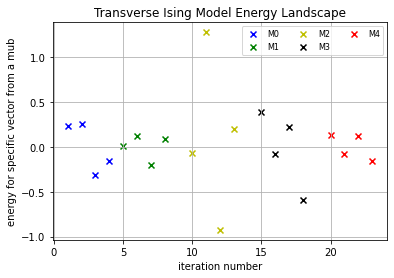

In [34]:
M0_points = plt.scatter(x=range(1,5),y=M0.results, marker='x', color=M0.color)
M1_points = plt.scatter(x=range(5,9),y=M1.results, marker='x', color=M1.color)
M2_points = plt.scatter(x=range(10,14),y=M2.results, marker='x', color=M2.color)
M3_points = plt.scatter(x=range(15,19),y=M3.results, marker='x', color=M3.color)
M4_points = plt.scatter(x=range(20,24),y=M4.results, marker='x', color=M4.color)

plt.legend((M0_points, M1_points, M2_points, M3_points, M4_points),
           (M0.name, M1.name, M2.name, M3.name, M4.name),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)

plt.xlabel('iteration number')
plt.ylabel('energy for specific vector from a mub')
plt.title('Transverse Ising Model Energy Landscape')
plt.grid()
plt.show()

In [38]:
initial_quantum_state = M2_vectors[2]
print(initial_quantum_state)

[0.5+0.j  0.5+0.j  0. +0.5j 0. -0.5j]


In [39]:
new_intial_quantum_state = np.vectorize(complex)([0.5,0.5,0,0],[0,0,0.5,-0.5])

### find the minimum eigenvalue

In [41]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, new_intial_quantum_state, post_processing_thetas=thetas)

QiskitError: 'Sum of amplitudes-squared does not equal one.'

Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1197377123258552

Approximation Error
0.09032668550419223


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


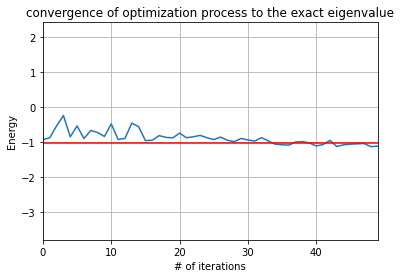

In [37]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [35]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

### pre-processing

In [36]:
thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)

In [37]:
for basis in mubs_d_5:
    basis.restart_results()
    for vector in basis.basis_vectors:
        pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(H2_molecule_Hamiltonian_2_qubits)
        ansatz_state = get_full_entangelment_ansatz(QUBITS_NUM, thetas, vector)

        L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        basis.add_result(L)

4it [00:00, 13.82it/s]
4it [00:00, 13.42it/s]
4it [00:00, 13.25it/s]
4it [00:00, 12.72it/s]
4it [00:00, 12.32it/s]
4it [00:00, 11.29it/s]
4it [00:00, 12.90it/s]
4it [00:00, 13.13it/s]
4it [00:00, 15.22it/s]
4it [00:00, 17.60it/s]
4it [00:00, 12.39it/s]
4it [00:00, 13.06it/s]
4it [00:00, 13.95it/s]
4it [00:00, 15.72it/s]
4it [00:00, 17.68it/s]
4it [00:00, 17.33it/s]
4it [00:00, 14.08it/s]
4it [00:00, 12.83it/s]
4it [00:00, 13.31it/s]
4it [00:00, 16.23it/s]


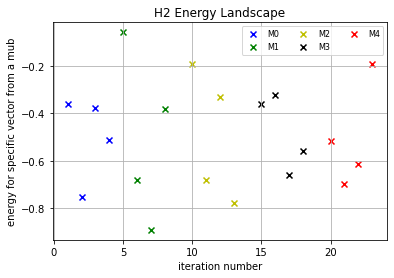

In [38]:
M0_points = plt.scatter(x=range(1,5),y=M0.results, marker='x', color=M0.color)
M1_points = plt.scatter(x=range(5,9),y=M1.results, marker='x', color=M1.color)
M2_points = plt.scatter(x=range(10,14),y=M2.results, marker='x', color=M2.color)
M3_points = plt.scatter(x=range(15,19),y=M3.results, marker='x', color=M3.color)
M4_points = plt.scatter(x=range(20,24),y=M4.results, marker='x', color=M4.color)

plt.legend((M0_points, M1_points, M2_points, M3_points, M4_points),
           (M0.name, M1.name, M2.name, M3.name, M4.name),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)

plt.xlabel('iteration number')
plt.ylabel('energy for specific vector from a mub')
plt.title('H2 Energy Landscape')
plt.grid()
plt.show()

In [64]:
initial_quantum_state = M1_vectors[2]

In [65]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, initial_quantum_state, post_processing_thetas=thetas)

4it [00:00, 11.64it/s]
4it [00:00, 10.47it/s]
4it [00:00, 10.02it/s]
4it [00:00, 11.38it/s]
4it [00:00,  9.74it/s]
4it [00:00,  9.17it/s]
4it [00:00, 10.94it/s]
4it [00:00, 11.18it/s]
4it [00:00, 10.95it/s]
4it [00:00, 11.64it/s]
4it [00:00, 11.47it/s]
4it [00:00, 11.05it/s]
4it [00:00,  9.84it/s]
4it [00:00, 10.65it/s]
4it [00:00,  8.29it/s]
4it [00:00,  8.30it/s]
4it [00:00,  9.64it/s]
4it [00:00,  8.03it/s]
4it [00:00,  9.51it/s]
4it [00:00,  9.08it/s]
4it [00:00,  9.81it/s]
4it [00:00, 10.36it/s]
4it [00:00,  9.74it/s]
4it [00:00, 10.57it/s]
4it [00:00, 10.89it/s]
4it [00:00,  8.06it/s]
4it [00:00,  9.38it/s]
4it [00:00, 10.24it/s]
4it [00:00, 10.67it/s]
4it [00:00, 10.66it/s]
4it [00:00,  9.96it/s]
4it [00:00, 11.49it/s]
4it [00:00, 12.49it/s]
4it [00:00, 11.78it/s]
4it [00:00, 11.26it/s]
4it [00:00, 11.46it/s]
4it [00:00, 11.01it/s]
4it [00:00, 10.80it/s]
4it [00:00, 10.86it/s]
4it [00:00, 11.19it/s]
4it [00:00, 10.53it/s]
4it [00:00, 10.44it/s]
4it [00:00, 12.95it/s]
4it [00:00,

CPU times: total: 18.3 s
Wall time: 20.1 s


Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9867833745118667

Approximation Error
0.018230233946649063


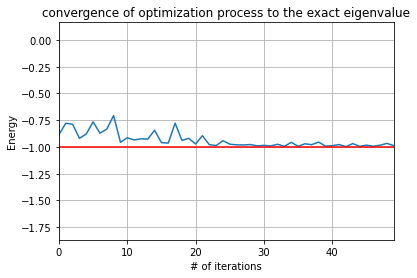

In [66]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)